1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [23]:
import numpy as np
from scipy import stats
import numpy.random as npr
import matplotlib.pyplot as plt
npr.seed(123)

In [24]:
def p_decay(t):
    tau = 3.052 #minutes
    return 1 - 2**(-t/tau)

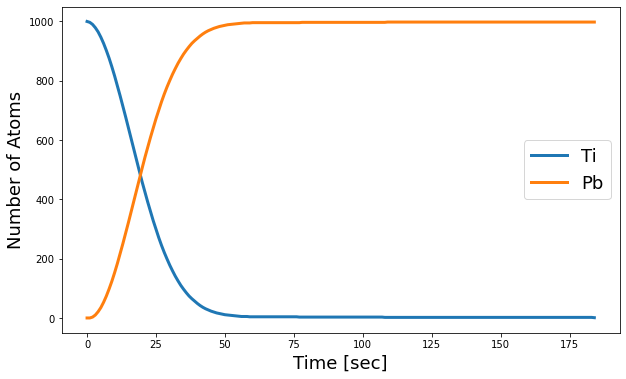

In [25]:
N_Ti_i = 1000 #Thallium atoms initial condition

N_Ti_t = [N_Ti_i]
N_Pb_t = [0]

t = 1./60
i = 0
while True:
    
    if(N_Ti_t[i] == 1):
        break;
    
    else:
        N_Ti_t.append(N_Ti_t[i] - int(p_decay(t)* N_Ti_t[i]))
        N_Pb_t.append(N_Ti_i - N_Ti_t[i])
        i += 1
        t += 1./60

N_Ti_t = np.array(N_Ti_t)
N_Pb_t = np.array(N_Pb_t)
t = np.arange(len(N_Pb_t))

fig = plt.figure(figsize=(10,6))

plt.plot(t,N_Ti_t, label='Ti', lw=3)
plt.plot(t,N_Pb_t, label='Pb', lw=3)

plt.ylabel('Number of Atoms', fontsize=18)
plt.xlabel('Time [sec]', fontsize=18)
plt.legend(fontsize=18)

In [26]:
def p_decay_inv(z):
    tau = 3.052 #minutes
    return -tau * np.log2(1 - z)

def inv_transform_rvs(N):
    return p_decay_inv(npr.rand(N))

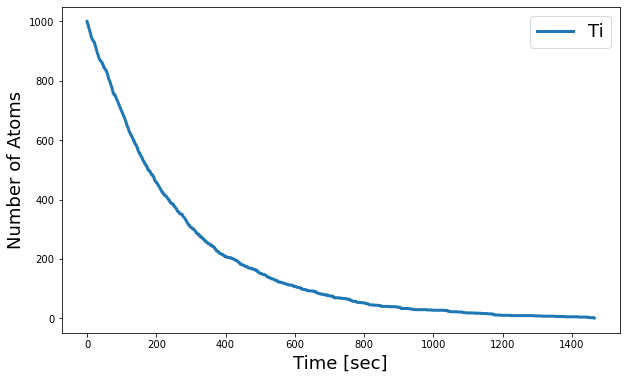

In [27]:
N = 1000

samples = inv_transform_rvs(N)

N_Ti_t = [N_Ti_i]
N_Pb_t = [0]

t = 1./60
i = 0

while True:
    
    if N_Ti_t[i] == 1:
        break
        
    else:
        N_Ti_t.append(N - np.count_nonzero(samples<t))
        t += 1./60
        i += 1
    
N_Ti_t = np.array(N_Ti_t)
t = np.arange(len(N_Ti_t))

fig = plt.figure(figsize=(10,6))

plt.plot(t,N_Ti_t, label='Ti', lw=3)

plt.ylabel('Number of Atoms', fontsize=18)
plt.xlabel('Time [sec]', fontsize=18)
plt.legend(fontsize=18)
    

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [28]:
import scipy.constants as const

In [29]:
N = 1000000
Z = 79
E = 7.7 * 1.6 * 10**(-13)
sigma = const.physical_constants['Bohr radius'][0]/100.

r_critic = Z * const.elementary_charge**2 / (2 * np.pi * const.epsilon_0 * E)

alfas_beam = sigma * npr.randn(N,2)

b_samples = np.sqrt(alfas_beam[:,0]**2 + alfas_beam[:,1]**2)

scattered_back = b_samples[b_samples<r_critic].size

fraction_scatter_back = scattered_back/N

In [30]:
scattered_back

1580

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [59]:
#there's something wrong (2 factor multiplied somewhere)
def f(x):
    return (np.sin(1/(x*(2.-x))))**2


N_points = 10000
#hit/miss

number_iterations = 1000
Integrals = []
for i in range(number_iterations):
    
    x_unif = npr.rand(N_points)*2
    y_unif = npr.rand(N_points)

    function_vals = f(x_unif)

    n_hits = np.sum(function_vals>y_unif)
    I_hit_miss = 2* n_hits/N_points
    
    Integrals.append(I_hit_miss)
    
Integrals = np.array(Integrals)

I_hit_miss = Integrals.mean()
error_hit_miss = Integrals.std()


#mean value

number_iterations = 1000
Integrals = []
for i in range(number_iterations):
    
    x_unif = npr.rand(N_points)*2
    function_vals = f(x_unif)
    
    I_mean_val = 2. * function_vals.mean()
    
    Integrals.append(I_mean_val)
    
Integrals = np.array(Integrals)

I_mean_val = Integrals.mean()
error_mean_val = Integrals.std()


print('Hit-Miss integral {:.4f} +- {:.4f}'.format(I_hit_miss, error_hit_miss))
print('I Mean Value integral {:.4f} +- {:.4f}'.format(I_mean_val, error_mean_val))


Hit-Miss integral 1.4515 +- 0.0091
I Mean Value integral 1.4516 +- 0.0054


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [73]:
N_points = 10000
x_unif = npr.rand(N_points)
y_unif = npr.rand(N_points)

area_circle = 4*np.sum( (x_unif**2 + y_unif**2) <= 1)/N_points
print('Area of the circle(R = 1) ', area_circle)
nsphere_points = npr.rand(N_points, 10)
volume = 4*np.sum(np.where(np.sum(nsphere_points**2, axis=1) <=1))/N_points
print('Volume of the 10D sphere', volume)

Area of the circle(R = 1)  3.1416
Volume of the 10D sphere 51.692


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [42]:
#I want x to be distributed as w(x)
#I use inverse transform method

def pdf(x):
    return 1./(2*np.sqrt(x))

def icdf(z):
    return np.power(z,2)

def f_over_w(x):
    return 1./(np.exp(x) + 1.)

N_points = 1000000
z_unif = npr.rand(N_points)
x_i_sampling = icdf(z_unif)


I = 2*np.mean(f_over_w(x_i_sampling))
I

0.8389519182199993